# Extra dependencies installation

In [1]:
!pip install vit-pytorch
!pip install torchviz
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 3.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=8e81ff09684988825325861c0431c8f56caadff75ecc6825e68baf789cd773fc
  Stored in directory: /root/.cache/pip/wheels/05/7d/1b/8306781244e42ede119edbb053bdcda1c1f424ca226165a417
Successfully built torchviz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [2]:
import os
import torch
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import psutil
import h5py
import os
import numpy as np
import time
import copy
from torchsummary import summary
from torch import optim
from torch.optim import lr_scheduler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from vit_pytorch import ViT
from math import sqrt
import torch
from torch.utils.tensorboard import SummaryWriter

import torch.nn.functional as F
from torch.nn import BCELoss
import torch.optim as pt_optim
import torch.optim.lr_scheduler as pt_lr_scheduler
from torchsummary import summary
import torch.nn as nn
import psutil
import time

from torchviz import make_dot

# Setup dataset 

In [3]:
try:
  import google.colab
  COLAB_ENV = True
except:
  COLAB_ENV = False


if COLAB_ENV:
  data_filepath = "/" + os.path.join("content","drive","MyDrive","datasets", "ML4SCI_GSOC23")
  from google.colab import drive
  drive.mount('/content/drive')
else:
  data_filepath = "data"

photon_file = "SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
electron_file = "SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

model_save_folder = os.path.join(data_filepath, "models")
tensorboard_save_folder = os.path.join(data_filepath, "tensorboard")

photon_filepath = os.path.join(data_filepath, photon_file)
electron_filepath = os.path.join(data_filepath, electron_file)

electronFile = h5py.File(electron_filepath, "r")
photonFile = h5py.File(photon_filepath, "r")

electronX, electronY = np.array(electronFile.get("X")), np.array(electronFile.get('y'))
photonX, photonY     = np.array(photonFile.get("X")),   np.array(photonFile.get('y'))

class PhotonElectronDataset(Dataset):
    def __init__(self, electron_indexes, photon_indexes, transform=None):
        assert len(electron_indexes) == len(photon_indexes)
        self.electron_indexes = electron_indexes
        self.photon_indexes = photon_indexes
        self.transform = transform

    def __len__(self):
        return len(self.electron_indexes) + len(self.photon_indexes)

    def __getitem__(self, idx):
        #image = torch.from_numpy(self.X[idx, :, :, :])

        # photon if even
        if idx % 2 == 0:
            image = photonX[self.photon_indexes[idx // 2], :, :, :]
            label = photonY[self.photon_indexes[idx // 2]]
        # electron if odd
        else:
            image = electronX[self.electron_indexes[idx // 2], :, :, :]
            label = electronY[self.electron_indexes[idx // 2]]

        if self.transform:
            image = self.transform(image)
        return image, label

Mounted at /content/drive


# EDA 
- just inspect the images, validate whether the dataset is correct

In [4]:
train_size = 0.8
validation_size = 0.1
test_size = 1 - train_size - validation_size

batch_size = 64

nElectronImgs = len(electronFile["X"])
nPhotonImgs = len(photonFile['y'])

electrons_idxs = np.arange(0, nElectronImgs)
np.random.shuffle(electrons_idxs)

photon_idxs = np.arange(0, nPhotonImgs)
np.random.shuffle(photon_idxs)

electron_training_idxs   = electrons_idxs[0: int(train_size * nElectronImgs)]
electron_validation_idxs = electrons_idxs[int(train_size * nElectronImgs) : int((train_size + validation_size) * nElectronImgs)]
electron_test_idxs       = electrons_idxs[int((train_size + validation_size) * nElectronImgs) :]

photon_training_idxs   = photon_idxs[0: int(train_size * nElectronImgs)]
photon_validation_idxs = photon_idxs[int(train_size * nElectronImgs) : int((train_size + validation_size) * nElectronImgs)]
photon_test_idxs       = photon_idxs[int((train_size + validation_size) * nElectronImgs) :]


training_dataset = PhotonElectronDataset(electron_training_idxs, photon_training_idxs, transform=transforms.Compose([transforms.ToTensor()]))
validation_dataset  = PhotonElectronDataset(electron_validation_idxs, photon_validation_idxs, transform=transforms.Compose([transforms.ToTensor()]))
testing_dataset  = PhotonElectronDataset(electron_test_idxs, photon_test_idxs, transform=transforms.Compose([transforms.ToTensor()]))

training_ds_size = len(training_dataset)
validation_ds_size = len(validation_dataset)
testing_ds_size = len(testing_dataset)

print(f"training size : {training_ds_size}")
print(f"validation size : {validation_ds_size}")
print(f"testing size : {testing_ds_size}")

train_dataloader      = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dataloader       = DataLoader(testing_dataset, batch_size=batch_size, shuffle=True)

training size : 398400
validation size : 49800
testing size : 49800


In [5]:
del photonFile, electronFile
del training_dataset, validation_dataset, testing_dataset

time.sleep(10)
memories = psutil.virtual_memory()
print(f"memory free left : {memories.free / 1000 / 1000 / 1000}Gb ; percentage left {100 - memories.percent}, available : {memories.available / 1000 / 1000 / 1000}")

memory free left : 17.322778624Gb ; percentage left 19.7, available : 21.933600768


torch.Size([64, 2, 32, 32])


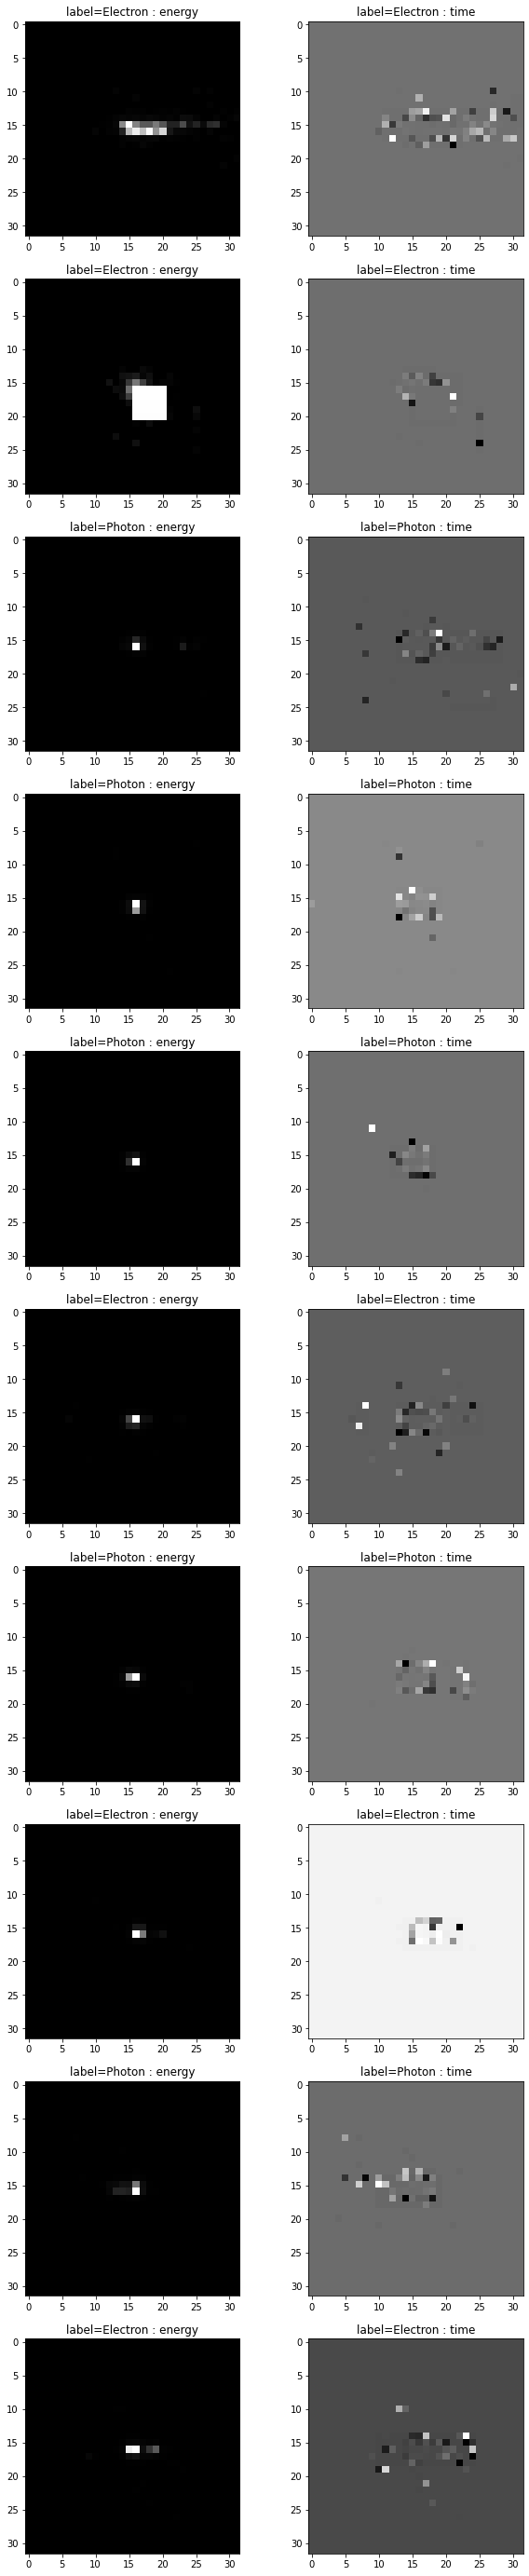

In [6]:
train_features, train_labels = next(iter(train_dataloader))
print(train_features.shape)
label_val_to_text = {1 : "Electron", 0 : "Photon"}

scale = 5
n = int(batch_size)
to_plot = 10
plt.figure(figsize=(2*scale , scale * to_plot))


for y in range(to_plot):
  plt.subplot(to_plot, 2, 2 * y + 1)
  label = label_val_to_text[train_labels[y].item()]
  plt.title(f"label={label} : energy")
  plt.imshow(train_features[y, 0, :, :], cmap='gray')

  plt.subplot(to_plot, 2, 2 * y + 2)
  plt.title(f"label={label} : time")
  plt.imshow(train_features[y, 1, :, :], cmap='gray')


plt.show()

# Pytorch Util functions 

training function and setting up tensorboard for monitoring

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Used : {device}")

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, saveTo, num_epochs=25):
    writer = SummaryWriter(tensorboard_save_folder)
    since = time.time()

    returnDict = {"trainingLoss" : [], "validationLoss" : [], "trainingAccuracy" : [], "validationAccuracy" : [], 
                  "epochs" : [], "trainingAUC" : [], "validationAUC" : []}
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        returnDict["epochs"].append(epoch)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            since2 = time.time()
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            y = torch.Tensor()
            pred_y = torch.Tensor()

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.long()

                y = torch.cat([y, labels.cpu()])
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    pred_labels = (outputs >= 0.5).reshape(-1)

                    #print(outputs.shape)
                    loss = criterion(outputs, labels.reshape(-1, 1).to(torch.float32))

                    pred_y = torch.cat([pred_y, outputs.cpu()])

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred_labels == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            AUC_ROC = roc_auc_score(y.detach().numpy(), pred_y.detach().numpy())  

            if phase == "train":
                returnDict["trainingLoss"].append(epoch_loss)
                returnDict["trainingAccuracy"].append(epoch_acc.cpu().item())
                returnDict["trainingAUC"].append(AUC_ROC)
                writer.add_scalar("Loss/train", epoch_loss, epoch)
                writer.add_scalar("Accuracy/train", epoch_acc.cpu().item(), epoch)
                writer.add_scalar("AUC/train", AUC_ROC, epoch)
            else:
                returnDict["validationLoss"].append(epoch_loss)
                returnDict["validationAccuracy"].append(epoch_acc.cpu().item())
                returnDict["validationAUC"].append(AUC_ROC)
                writer.add_scalar("Loss/validation", epoch_loss, epoch)
                writer.add_scalar("Accuracy/validation", epoch_acc.cpu().item(), epoch)
                writer.add_scalar("AUC/validation", AUC_ROC, epoch)


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC ROC : {AUC_ROC:.4f} Time taken : {round(time.time() - since2, 2)}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save({ "state_dict" : model.state_dict()}, saveTo)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    returnDict["best_model"] = model
    writer.close()
    return returnDict

Device Used : cuda:0


In [8]:
def plotResults(results):
    plt.figure(figsize=(16,12))
    plt.subplot(3,1, 1)
    plt.plot(results['epochs'], results['trainingLoss'], label="training Loss")
    plt.plot(results['epochs'], results['validationLoss'], label="validation Loss")
    plt.legend()

    plt.subplot(3,1, 2)
    plt.plot(results['epochs'], results['trainingAccuracy'], label="training Accuracy")
    plt.plot(results['epochs'], results['validationAccuracy'], label="validation Accuracy")
    plt.legend()
  
  
    plt.subplot(3,1, 3)
    plt.plot(results['epochs'], results['trainingAUC'], label="training ROC")
    plt.plot(results['epochs'], results['validationAUC'], label="validation AUC ROC")
    plt.plot([0, results['epochs'][-1]], [0.8, 0.8], "--", color='black')
    plt.legend()

    plt.show()

# Baseline

minimal simple architecture that provide some baseline accuracy

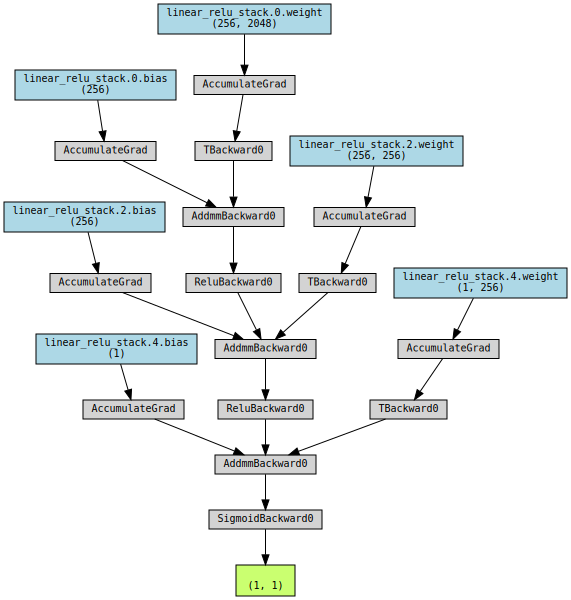

In [ ]:
class BasicNN(nn.Module):
    def __init__(self):
        super(BasicNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2* 32 * 32, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model_ft = BasicNN()
model_ft = model_ft.to(device)

y = model_ft(torch.Tensor(np.zeros((1, 2, 32,32))).to(device))
make_dot(y, params=dict(model_ft.named_parameters()))

In [ ]:
summary(model_ft, input_size=(32,32, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2048]               0
            Linear-2                  [-1, 256]         524,544
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 256]          65,792
              ReLU-5                  [-1, 256]               0
            Linear-6                    [-1, 1]             257
           Sigmoid-7                    [-1, 1]               0
Total params: 590,593
Trainable params: 590,593
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 2.25
Estimated Total Size (MB): 2.28
----------------------------------------------------------------


In [ ]:
optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 10, 0.9)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "Simple.pt"))

2023-02-28 19:47:24.835363: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 0/24
----------
train Loss: 0.6417 Acc: 0.6339 AUC ROC : 0.6771 Time taken : 22.11
val Loss: 0.6233 Acc: 0.6577 AUC ROC : 0.7069 Time taken : 1.34

Epoch 1/24
----------
train Loss: 0.6030 Acc: 0.6809 AUC ROC : 0.7349 Time taken : 20.8
val Loss: 0.6054 Acc: 0.6803 AUC ROC : 0.7333 Time taken : 1.28

Epoch 2/24
----------
train Loss: 0.5809 Acc: 0.7000 AUC ROC : 0.7611 Time taken : 20.98
val Loss: 0.6050 Acc: 0.6847 AUC ROC : 0.7359 Time taken : 1.29

Epoch 3/24
----------
train Loss: 0.5578 Acc: 0.7173 AUC ROC : 0.7849 Time taken : 21.86
val Loss: 0.6107 Acc: 0.6807 AUC ROC : 0.7327 Time taken : 1.62

Epoch 4/24
----------
train Loss: 0.5307 Acc: 0.7353 AUC ROC : 0.8096 Time taken : 28.44
val Loss: 0.6273 Acc: 0.6752 AUC ROC : 0.7252 Time taken : 1.71

Epoch 5/24
----------
train Loss: 0.5049 Acc: 0.7521 AUC ROC : 0.8306 Time taken : 28.22
val Loss: 0.6589 Acc: 0.6742 AUC ROC : 0.7218 Time taken : 1.81

Epoch 6/24
----------
train Loss: 0.4808 Acc: 0.7664 AUC ROC : 0.8481 Time ta

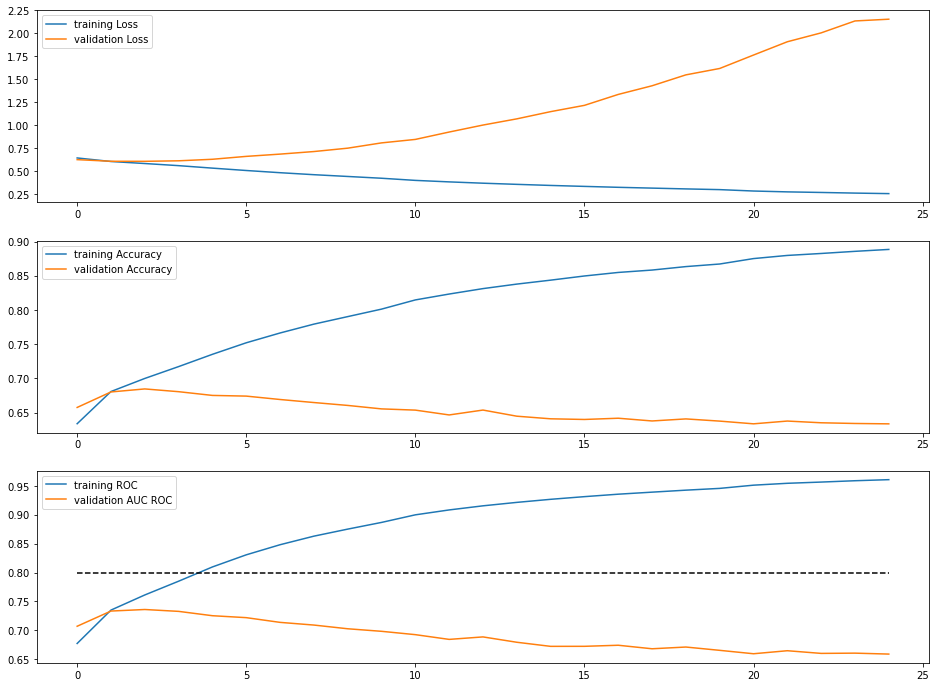

In [ ]:
plotResults(simple_res)

## Analysis
MLP overfits significantly (only in few first epochs we see some improvement for validation dataset, after that significant decay in performance)

# Basic CNN

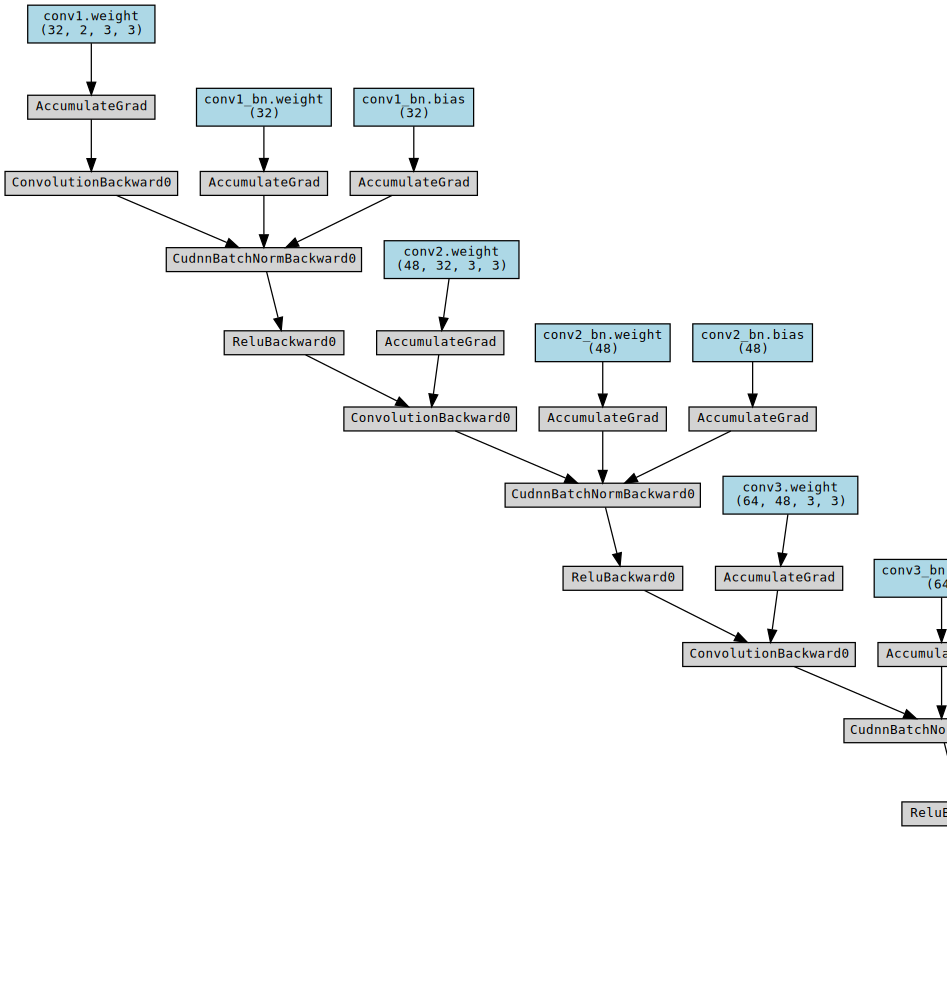

In [9]:
class ModelM3(nn.Module):
    def __init__(self):
        super(ModelM3, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 48, 3, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 64, 3, bias=False)      # output becomes 22x22
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 80, 3, bias=False)      # output becomes 20x20
        self.conv4_bn = nn.BatchNorm2d(80)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(11520, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = (x - 0.5) * 2.0
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv5 = self.max_pool(conv4)
        flat1 = torch.flatten(conv5.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

model_ft = ModelM3()
model_ft = model_ft.to(device)

y = model_ft(torch.Tensor(np.zeros((1, 2, 32,32))).to(device))
make_dot(y, params=dict(model_ft.named_parameters()))

In [10]:
summary(model_ft, input_size=(2, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             576
       BatchNorm2d-2           [-1, 32, 30, 30]              64
            Conv2d-3           [-1, 48, 28, 28]          13,824
       BatchNorm2d-4           [-1, 48, 28, 28]              96
            Conv2d-5           [-1, 64, 26, 26]          27,648
       BatchNorm2d-6           [-1, 64, 26, 26]             128
            Conv2d-7           [-1, 80, 24, 24]          46,080
       BatchNorm2d-8           [-1, 80, 24, 24]             160
         MaxPool2d-9           [-1, 80, 12, 12]               0
           Linear-10                    [-1, 1]          11,520
          Sigmoid-11                    [-1, 1]               0
Total params: 100,096
Trainable params: 100,096
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [11]:
optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 10, 0.9)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN.pth"))

Epoch 0/24
----------
train Loss: 0.6243 Acc: 0.6592 AUC ROC : 0.7107 Time taken : 77.71
val Loss: 0.5963 Acc: 0.6913 AUC ROC : 0.7505 Time taken : 3.81

Epoch 1/24
----------
train Loss: 0.5824 Acc: 0.7027 AUC ROC : 0.7611 Time taken : 75.57
val Loss: 2.4088 Acc: 0.5007 AUC ROC : 0.7210 Time taken : 3.84

Epoch 2/24
----------
train Loss: 0.5689 Acc: 0.7133 AUC ROC : 0.7751 Time taken : 75.55
val Loss: 0.5764 Acc: 0.7129 AUC ROC : 0.7753 Time taken : 3.8

Epoch 3/24
----------
train Loss: 0.5621 Acc: 0.7177 AUC ROC : 0.7820 Time taken : 76.01
val Loss: 0.7534 Acc: 0.6287 AUC ROC : 0.7483 Time taken : 4.02

Epoch 4/24
----------
train Loss: 0.5583 Acc: 0.7204 AUC ROC : 0.7856 Time taken : 76.32
val Loss: 0.6017 Acc: 0.7043 AUC ROC : 0.7738 Time taken : 3.84

Epoch 5/24
----------
train Loss: 0.5554 Acc: 0.7225 AUC ROC : 0.7885 Time taken : 76.01
val Loss: 0.5591 Acc: 0.7198 AUC ROC : 0.7870 Time taken : 3.91

Epoch 6/24
----------
train Loss: 0.5526 Acc: 0.7252 AUC ROC : 0.7913 Time ta

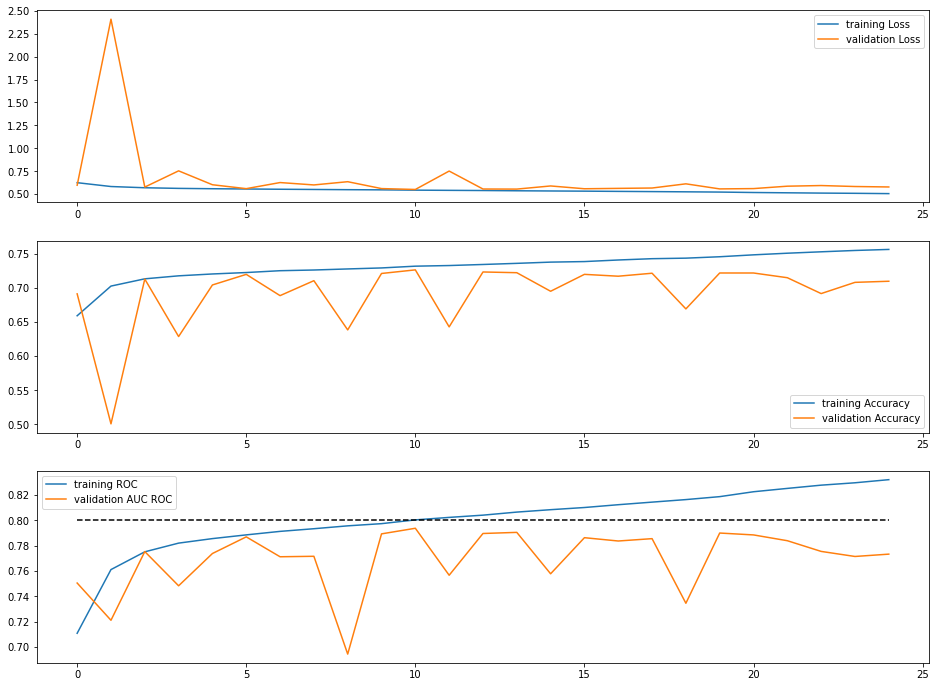

In [13]:
plotResults(simple_res)

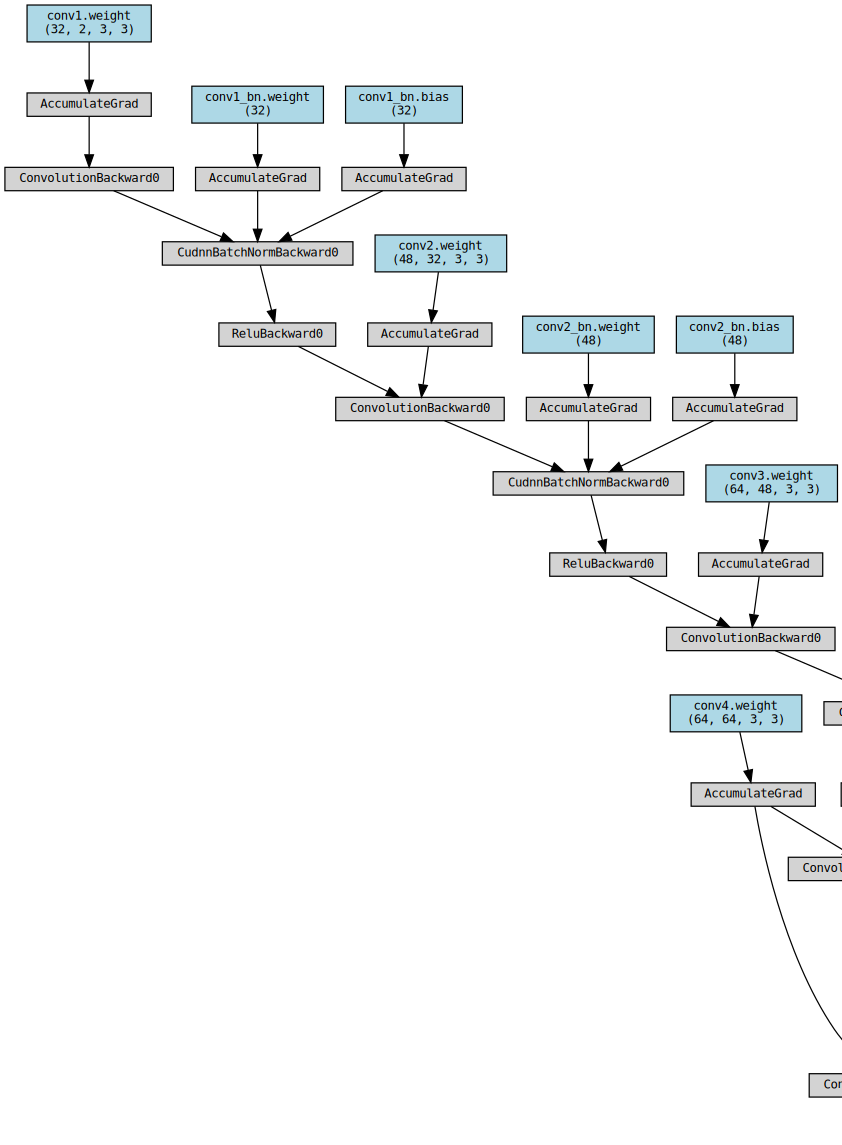

In [16]:
class ModelM3(nn.Module):
    def __init__(self):
        super(ModelM3, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 48, 3, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 64, 3, bias=False)      # output becomes 22x22
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, bias=False)      # output becomes 20x20
        self.conv4_bn = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 3, bias=False)      # output becomes 18x18
        self.conv5_bn = nn.BatchNorm2d(64)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(7744, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = (x - 0.5) * 2.0
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv5 = F.relu(self.conv5_bn(self.conv4(conv4)))
        max_pool = self.max_pool(conv5)
        flat1 = torch.flatten(max_pool.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

model_ft = ModelM3()
model_ft = model_ft.to(device)

y = model_ft(torch.Tensor(np.zeros((1, 2, 32,32))).to(device))
make_dot(y, params=dict(model_ft.named_parameters()))

In [17]:
summary(model_ft, input_size=(2, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             576
       BatchNorm2d-2           [-1, 32, 30, 30]              64
            Conv2d-3           [-1, 48, 28, 28]          13,824
       BatchNorm2d-4           [-1, 48, 28, 28]              96
            Conv2d-5           [-1, 64, 26, 26]          27,648
       BatchNorm2d-6           [-1, 64, 26, 26]             128
            Conv2d-7           [-1, 64, 24, 24]          36,864
       BatchNorm2d-8           [-1, 64, 24, 24]             128
            Conv2d-9           [-1, 64, 22, 22]          36,864
      BatchNorm2d-10           [-1, 64, 22, 22]             128
        MaxPool2d-11           [-1, 64, 11, 11]               0
           Linear-12                    [-1, 1]           7,744
          Sigmoid-13                    [-1, 1]               0
Total params: 124,064
Trainable params:

In [20]:
optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN2.pth"))

Epoch 0/24
----------
train Loss: 0.6039 Acc: 0.6830 AUC ROC : 0.7359 Time taken : 83.6
val Loss: 3.1312 Acc: 0.5000 AUC ROC : 0.7223 Time taken : 4.25

Epoch 1/24
----------
train Loss: 0.5765 Acc: 0.7075 AUC ROC : 0.7665 Time taken : 84.75
val Loss: 0.5830 Acc: 0.7005 AUC ROC : 0.7714 Time taken : 4.2

Epoch 2/24
----------
train Loss: 0.5658 Acc: 0.7158 AUC ROC : 0.7778 Time taken : 84.36
val Loss: 0.7235 Acc: 0.4851 AUC ROC : 0.4290 Time taken : 4.2

Epoch 3/24
----------
train Loss: 0.5603 Acc: 0.7190 AUC ROC : 0.7834 Time taken : 84.44
val Loss: 0.5972 Acc: 0.6860 AUC ROC : 0.7596 Time taken : 4.33

Epoch 4/24
----------
train Loss: 0.5568 Acc: 0.7222 AUC ROC : 0.7870 Time taken : 85.19
val Loss: 0.5791 Acc: 0.7079 AUC ROC : 0.7750 Time taken : 4.44

Epoch 5/24
----------
train Loss: 0.5534 Acc: 0.7243 AUC ROC : 0.7903 Time taken : 84.88
val Loss: 0.5804 Acc: 0.6993 AUC ROC : 0.7799 Time taken : 4.29

Epoch 6/24
----------
train Loss: 0.5509 Acc: 0.7261 AUC ROC : 0.7926 Time take

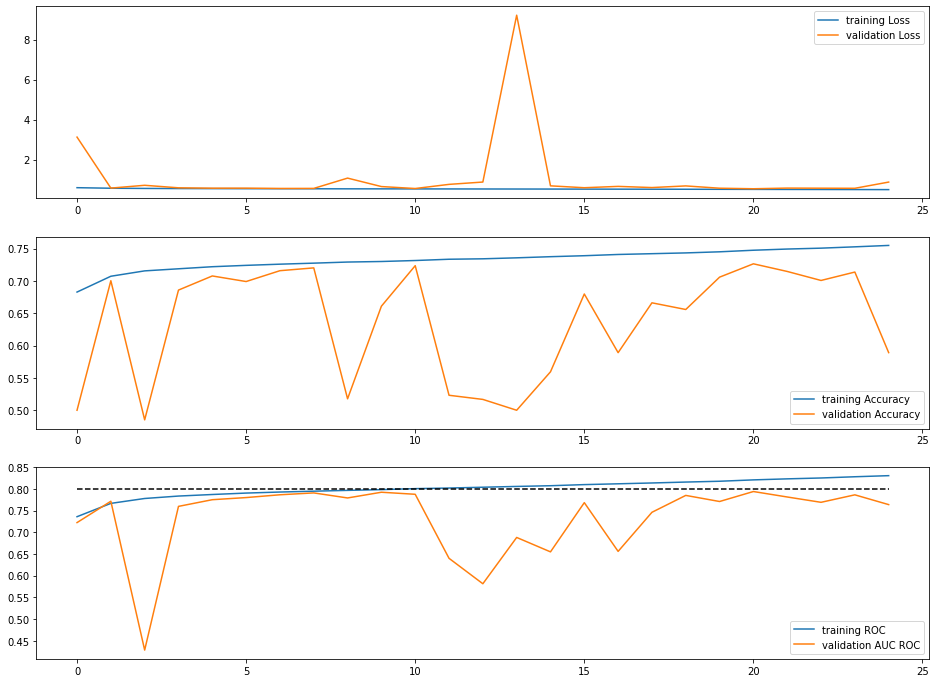

In [21]:
plotResults(simple_res)

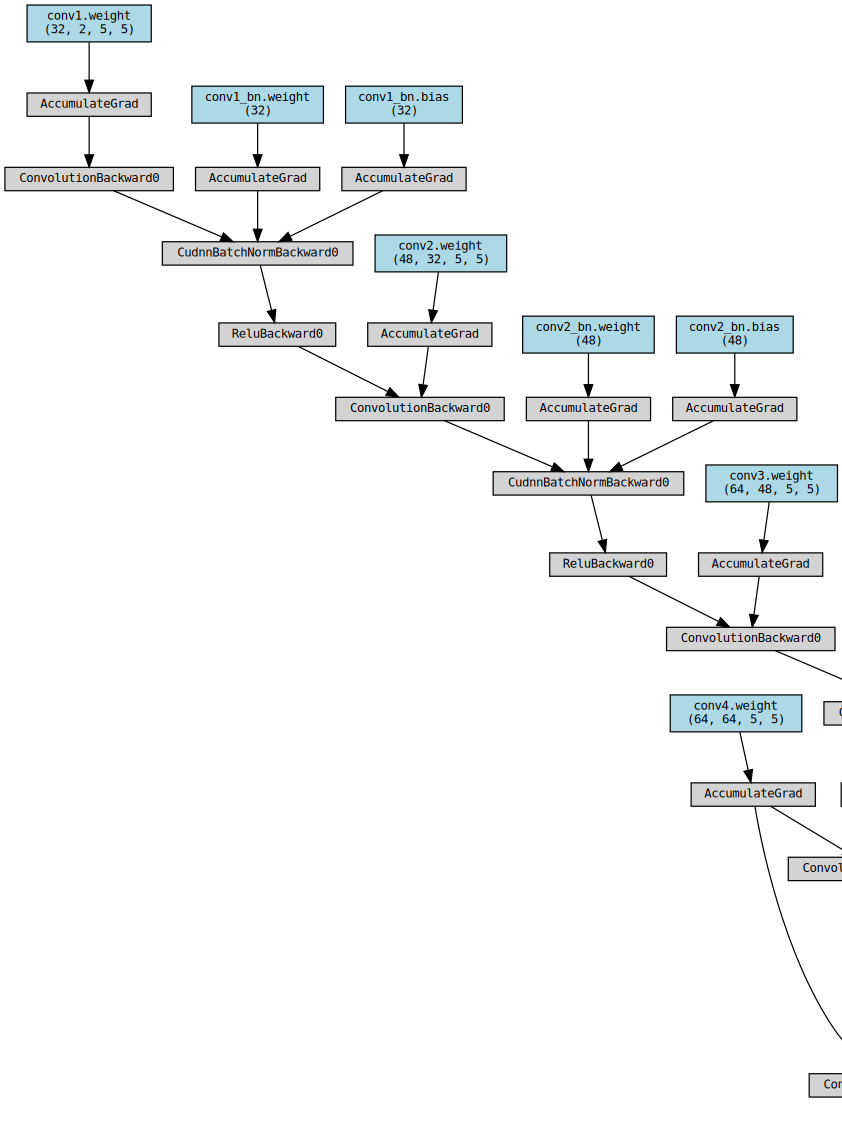

In [24]:
class ModelM5(nn.Module):
    def __init__(self):
        super(ModelM5, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 5, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 48, 5, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 64, 5, bias=False)      # output becomes 22x22
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 20x20
        self.conv4_bn = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 18x18
        self.conv5_bn = nn.BatchNorm2d(64)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(2304, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = (x - 0.5) * 2.0
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv5 = F.relu(self.conv5_bn(self.conv4(conv4)))
        max_pool = self.max_pool(conv5)
        flat1 = torch.flatten(max_pool.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

model_ft = ModelM5()
model_ft = model_ft.to(device)

y = model_ft(torch.Tensor(np.zeros((1, 2, 32,32))).to(device))
make_dot(y, params=dict(model_ft.named_parameters()))

In [25]:
summary(model_ft, input_size=(2, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]           1,600
       BatchNorm2d-2           [-1, 32, 28, 28]              64
            Conv2d-3           [-1, 48, 24, 24]          38,400
       BatchNorm2d-4           [-1, 48, 24, 24]              96
            Conv2d-5           [-1, 64, 20, 20]          76,800
       BatchNorm2d-6           [-1, 64, 20, 20]             128
            Conv2d-7           [-1, 64, 16, 16]         102,400
       BatchNorm2d-8           [-1, 64, 16, 16]             128
            Conv2d-9           [-1, 64, 12, 12]         102,400
      BatchNorm2d-10           [-1, 64, 12, 12]             128
        MaxPool2d-11             [-1, 64, 6, 6]               0
           Linear-12                    [-1, 1]           2,304
          Sigmoid-13                    [-1, 1]               0
Total params: 324,448
Trainable params:

In [27]:
optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN3.pth"))

Epoch 0/24
----------
train Loss: 0.6020 Acc: 0.6812 AUC ROC : 0.7366 Time taken : 67.46
val Loss: 1.5182 Acc: 0.5000 AUC ROC : 0.5537 Time taken : 3.75

Epoch 1/24
----------
train Loss: 0.5677 Acc: 0.7143 AUC ROC : 0.7757 Time taken : 67.72
val Loss: 0.7817 Acc: 0.5084 AUC ROC : 0.7503 Time taken : 3.65

Epoch 2/24
----------
train Loss: 0.5600 Acc: 0.7197 AUC ROC : 0.7838 Time taken : 67.81
val Loss: 0.6247 Acc: 0.6683 AUC ROC : 0.7371 Time taken : 3.69

Epoch 3/24
----------
train Loss: 0.5547 Acc: 0.7238 AUC ROC : 0.7888 Time taken : 67.71
val Loss: 3.3525 Acc: 0.5000 AUC ROC : 0.6736 Time taken : 3.7

Epoch 4/24
----------
train Loss: 0.5513 Acc: 0.7256 AUC ROC : 0.7921 Time taken : 68.12
val Loss: 0.9081 Acc: 0.5181 AUC ROC : 0.5225 Time taken : 3.79

Epoch 5/24
----------
train Loss: 0.5481 Acc: 0.7288 AUC ROC : 0.7952 Time taken : 67.9
val Loss: 0.8154 Acc: 0.5214 AUC ROC : 0.5636 Time taken : 3.71

Epoch 6/24
----------
train Loss: 0.5452 Acc: 0.7306 AUC ROC : 0.7980 Time tak

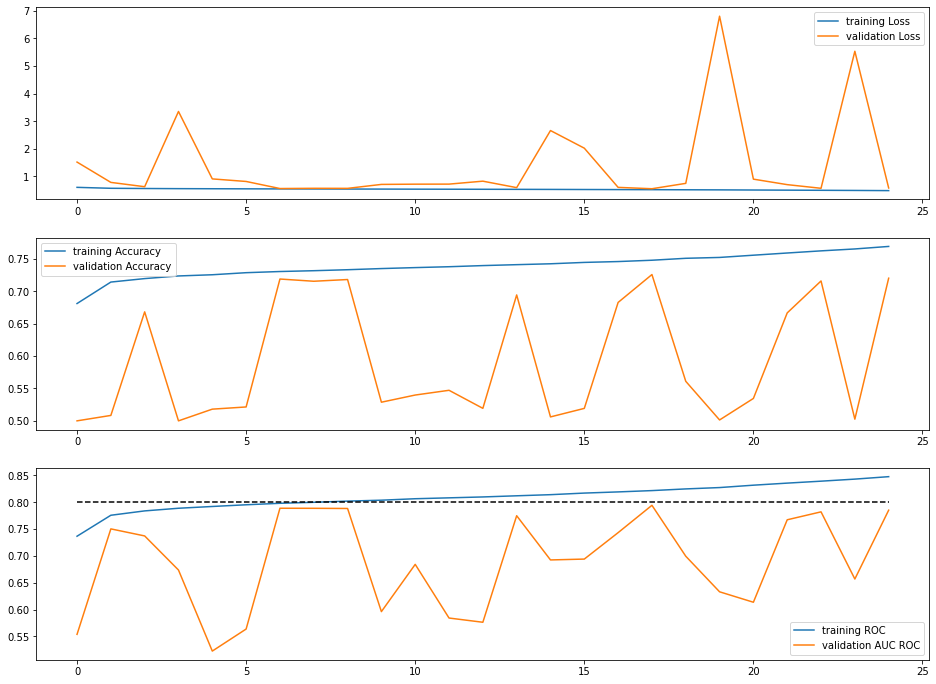

In [28]:
plotResults(simple_res)

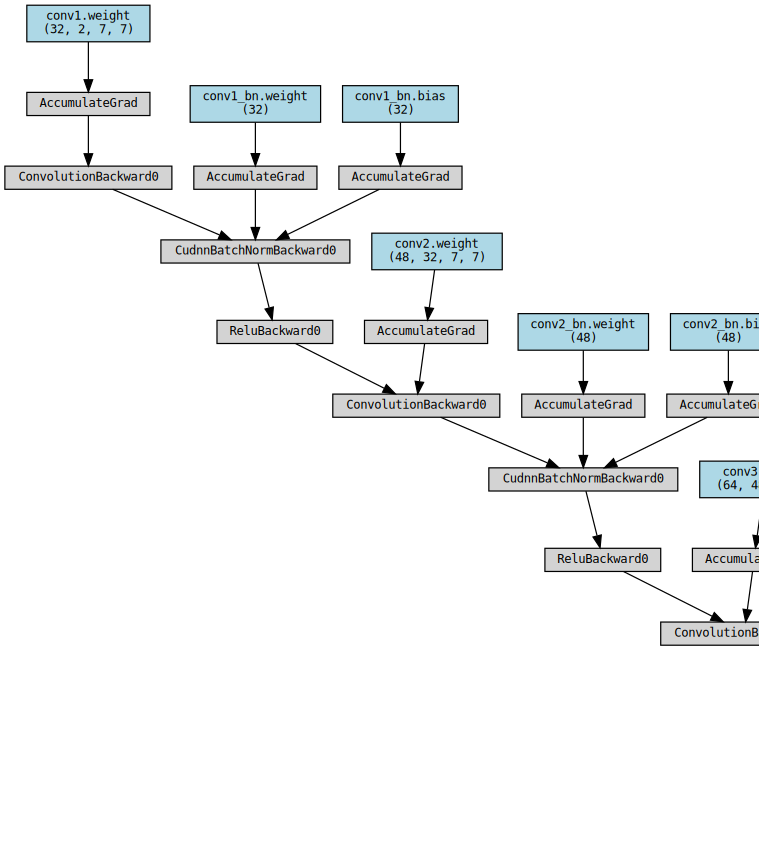

In [33]:
class ModelM7(nn.Module):
    def __init__(self):
        super(ModelM7, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 7, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 48, 7, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 64, 7, bias=False)      # output becomes 22x22
        self.conv3_bn = nn.BatchNorm2d(64)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(3136, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = (x - 0.5) * 2.0
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        max_pool = self.max_pool(conv3)
        flat1 = torch.flatten(max_pool.permute(0, 2, 3, 1), 1)
        logits = self.fc1(flat1)
        return self.sigmoid(logits)

model_ft = ModelM7()
model_ft = model_ft.to(device)

y = model_ft(torch.Tensor(np.zeros((1, 2, 32,32))).to(device))
make_dot(y, params=dict(model_ft.named_parameters()))

In [34]:
summary(model_ft, input_size=(2, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]           3,136
       BatchNorm2d-2           [-1, 32, 26, 26]              64
            Conv2d-3           [-1, 48, 20, 20]          75,264
       BatchNorm2d-4           [-1, 48, 20, 20]              96
            Conv2d-5           [-1, 64, 14, 14]         150,528
       BatchNorm2d-6           [-1, 64, 14, 14]             128
         MaxPool2d-7             [-1, 64, 7, 7]               0
            Linear-8                    [-1, 1]           3,136
           Sigmoid-9                    [-1, 1]               0
Total params: 232,352
Trainable params: 232,352
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.84
Params size (MB): 0.89
Estimated Total Size (MB): 1.73
-------------------------------------------

In [35]:
optim = pt_optim.Adam(model_ft.parameters())
lr_sched = pt_lr_scheduler.StepLR(optim, 5, 0.95)
dataloaders = {
    "train" : train_dataloader,
    "val" : validation_dataloader
}

dataset_sizes = {
    "train" : training_ds_size,
    "val" : validation_ds_size
}

simple_res = train_model(model_ft, F.binary_cross_entropy, optim, lr_sched, dataloaders, dataset_sizes, os.path.join(model_save_folder, "BasicCNN3.pth"))

Epoch 0/24
----------
train Loss: 0.6190 Acc: 0.6608 AUC ROC : 0.7149 Time taken : 45.07
val Loss: 49.9949 Acc: 0.5000 AUC ROC : 0.5000 Time taken : 2.84

Epoch 1/24
----------
train Loss: 0.5719 Acc: 0.7105 AUC ROC : 0.7713 Time taken : 44.98
val Loss: 0.7014 Acc: 0.5168 AUC ROC : 0.5314 Time taken : 2.86

Epoch 2/24
----------
train Loss: 0.5609 Acc: 0.7193 AUC ROC : 0.7827 Time taken : 45.04
val Loss: 0.7918 Acc: 0.5018 AUC ROC : 0.5414 Time taken : 2.84

Epoch 3/24
----------
train Loss: 0.5551 Acc: 0.7238 AUC ROC : 0.7885 Time taken : 45.25
val Loss: 0.6275 Acc: 0.6895 AUC ROC : 0.7717 Time taken : 2.96

Epoch 4/24
----------
train Loss: 0.5501 Acc: 0.7266 AUC ROC : 0.7933 Time taken : 45.0
val Loss: 3.0957 Acc: 0.5004 AUC ROC : 0.4688 Time taken : 2.96

Epoch 5/24
----------
train Loss: 0.5450 Acc: 0.7307 AUC ROC : 0.7983 Time taken : 44.79
val Loss: 0.7522 Acc: 0.5201 AUC ROC : 0.5233 Time taken : 3.07

Epoch 6/24
----------
train Loss: 0.5403 Acc: 0.7335 AUC ROC : 0.8025 Time t

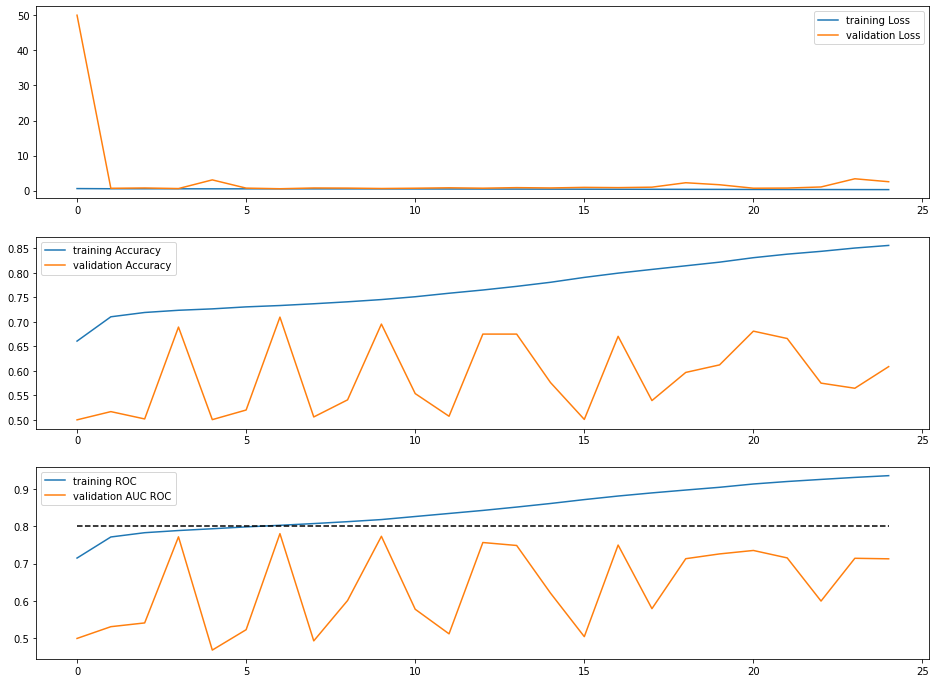

In [36]:
plotResults(simple_res)